The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
from IPython.display import display, clear_output

In [4]:
import sys
sys.path.append('../../..')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [6]:
from magrec.misc.load import load_matlab_data

Loaded data of shape (4, 125, 55), padded up to torch.Size([4, 125, 55]), with spacing dx = 0.020 μm, dy = 0.029 μm


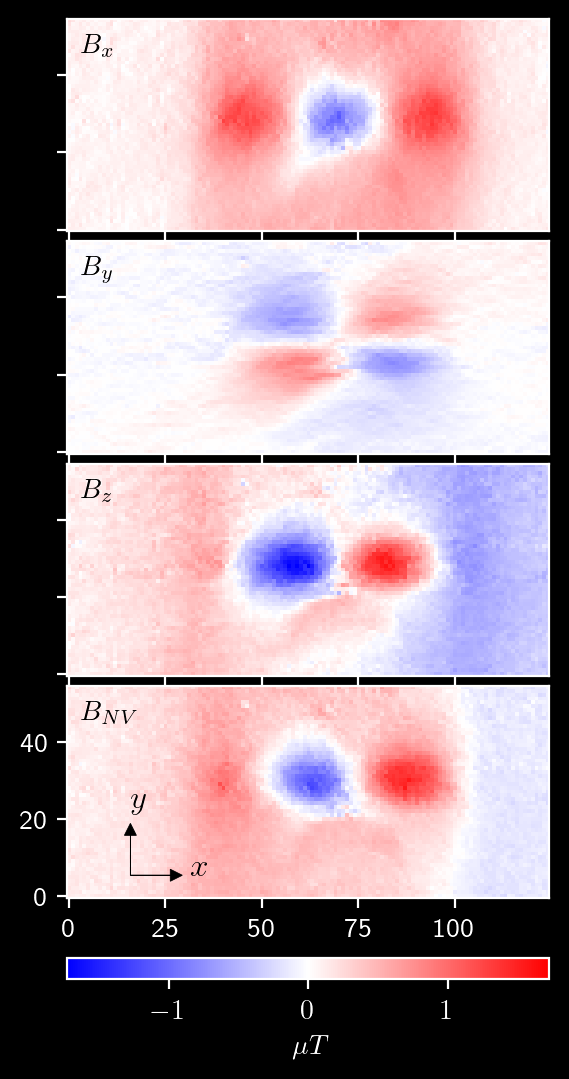

In [7]:
mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")

Bx = mat['BX_map'].T
By = mat['BY_map'].T
Bz = mat['BZ_map'].T
Bnv = mat['Bnv_map'].T

B = np.stack((Bx, By, Bz, Bnv), axis=0)
original_shape = B.shape

# make roi slice obejct out of the original shape, assuming the data starts at (0, 0)
roi_original = (slice(None), slice(original_shape[-2]), slice(original_shape[-1]))

B = B * 1e6 # convert to μT

B = torch.tensor(B, dtype=torch.float32)

# find mean spacing between points, assuming uniform (more or less) grid
dx = np.diff(mat['rx_inv']).mean()
dy = np.diff(mat['ry_inv']).mean()

print(f'Loaded data of shape {original_shape}, padded up to {B.shape}, with spacing dx = {dx:.3f} μm, dy = {dy:.3f} μm')

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

# Show how the data looks like
plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units=r"$\mu T$", alignment="vertical",)

# Neural net architecture

In [46]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
    FourierDivergence2d,
)

from magrec.scripts.prototype_pipeline import Prototype

from magrec.nn.arch import UNet, BnCNN, FCCNN

In [9]:
from magrec.scripts.prototype_pipeline import Prototype

In [28]:

pipe = Pipe([
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults()),
    ('B_NV', Function(lambda x: x[None, 0:1, :, :])),
    ('padded_B_NV', padder),
])

model = Pipe([
    ('JxJy', Union([('Jx', 'passthrough'), ('Jy', FourierZeroDivergenceConstraint2d(k00=0.0))], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[:, 0:1, :, :])),
])

recon = Prototype(net=UNet, model=model, pipe=pipe, max_epochs=20, n_channels_in=1, n_channels_out=1)

  epoch    train_loss       dur
-------  ------------  --------
      1      2.03e-01  8.32e-02
     20      1.98e-01  9.72e-02
     40      5.04e-02  9.31e-02
     60      1.79e-02  9.70e-02
     80      9.20e-03  1.10e-01
    100      6.05e-03  7.46e-02
    120      3.92e-03  8.00e-02
    140      1.71e-03  6.18e-02
    160      7.64e-04  5.83e-02
    180      9.00e-04  6.34e-02
    200      8.57e-04  6.85e-02


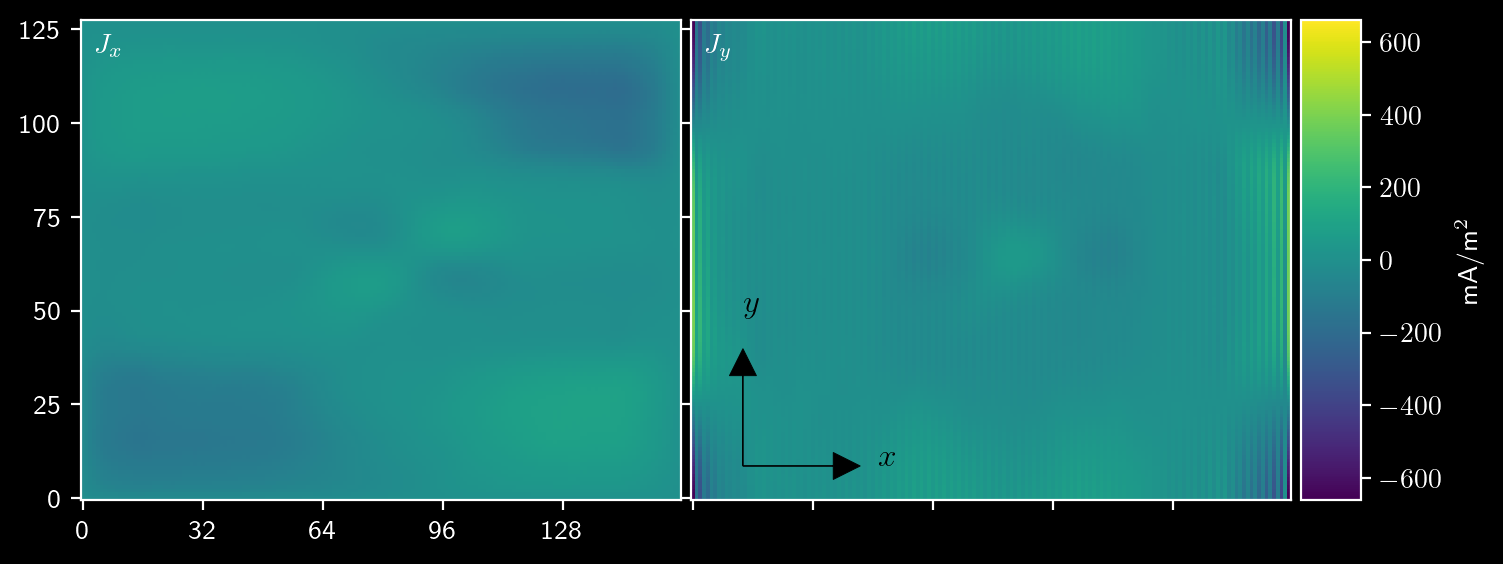

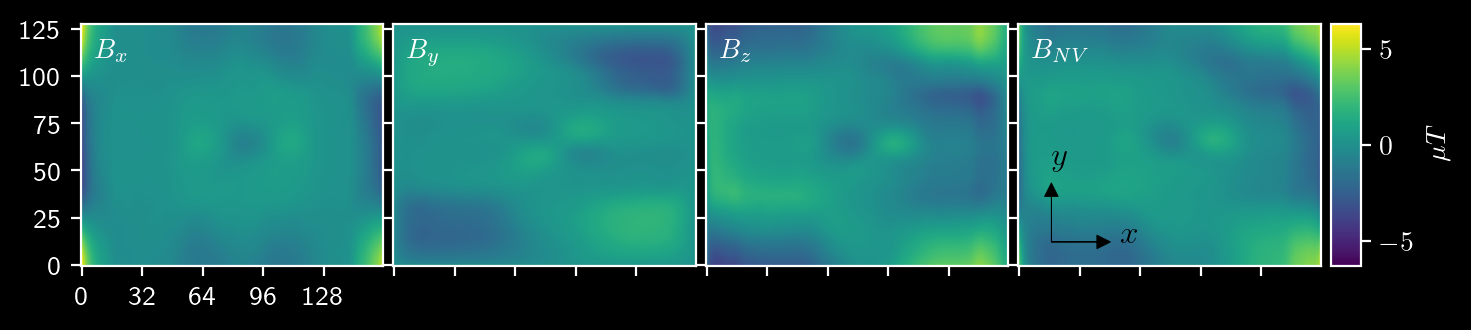

tensor([[[[6.2993, 6.2485, 6.1592,  ..., 6.2059, 6.2633, 6.3012],
          [5.0099, 4.9755, 4.9076,  ..., 4.9157, 4.9681, 5.0049],
          [4.2273, 4.2000, 4.1439,  ..., 4.1402, 4.1870, 4.2206],
          ...,
          [4.3304, 4.2792, 4.2120,  ..., 4.3568, 4.3680, 4.3604],
          [4.7318, 4.6808, 4.6093,  ..., 4.7395, 4.7583, 4.7575],
          [6.1587, 6.1014, 6.0113,  ..., 6.1087, 6.1515, 6.1735]]]],
       grad_fn=<SliceBackward0>)

In [29]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=1)

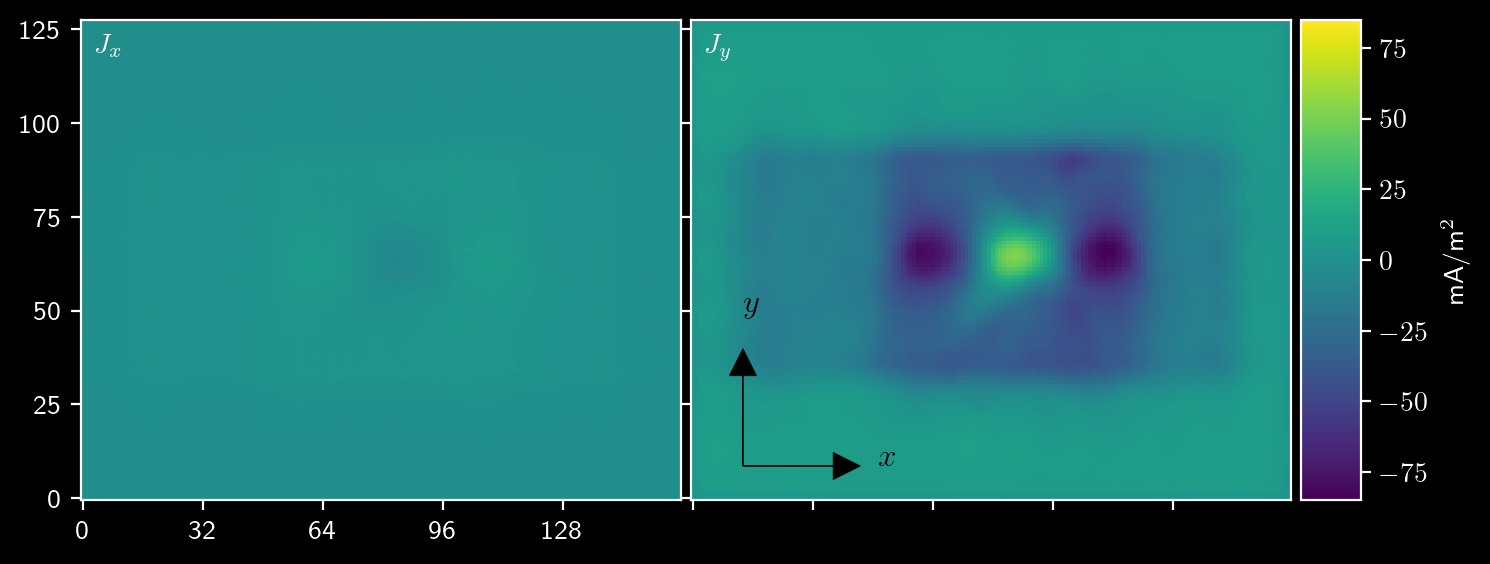

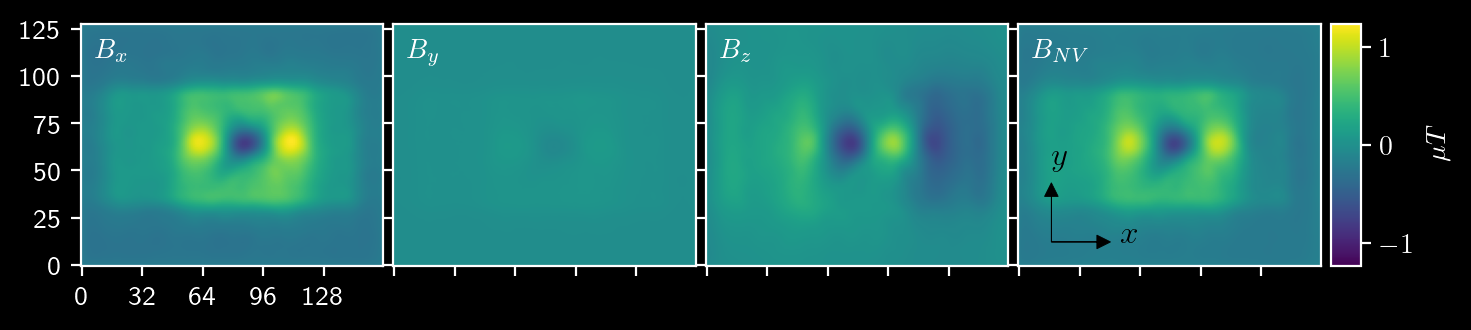

torch.Size([1, 1, 160, 128])

In [18]:
recon.propagate(B, epochs=0).shape

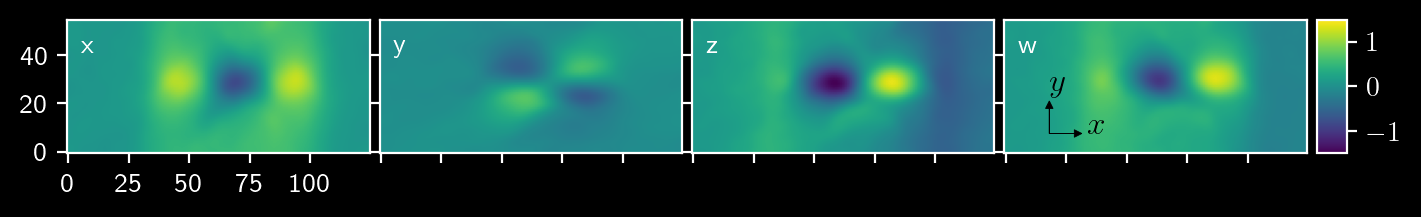

In [50]:
padder = Padder(up_to=(16*12, 16*8))

pipe = Pipe([
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults()),
    ('B_NV', Function(lambda x: x[None, 0:1, :, :])),
    ('padded_B_NV', padder),
])

pipe.fit(B).transform(B);

padding = padder.padding
threshold = -0.2
mask = torch.where(B.abs()[0] > threshold, torch.ones_like(B[0]), torch.zeros_like(B[0]))
mask = torch.nn.functional.pad(mask, (padding[-1], padding[-2], 0, 0), mode='constant', value=1.0)
mask = torch.nn.functional.pad(mask, (0, 0, padding[-3], padding[-4]), mode='constant', value=0.0)
def apply_mask(x):
    masked_x = mask * x
    return masked_x

mask_fn = Function(apply_mask)

model = Pipe([
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('mask', mask_fn),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=FCCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

In [53]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=1)


  epoch    train_loss       dur
-------  ------------  --------
    333      3.03e-02  2.53e-01
    340      1.83e-01  1.99e-01
    360      6.20e-02  2.05e-01
    380      4.73e-02  2.71e-01
    400      1.38e-01  1.92e-01
    420      1.07e-01  2.06e-01
    440      2.64e-02  1.53e-01
    460      2.75e-02  1.44e-01
    480      6.80e-02  1.90e-01


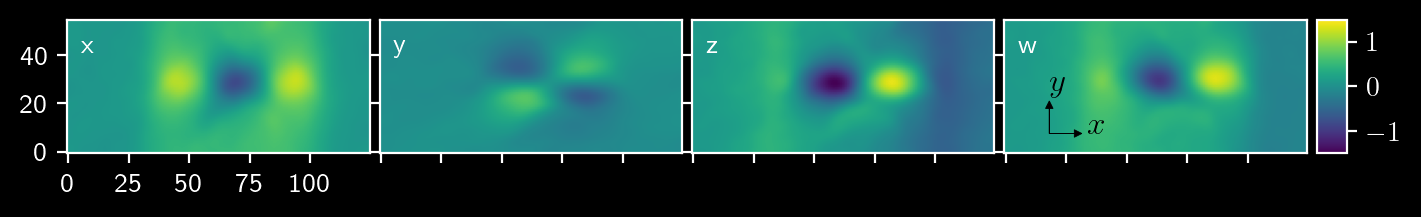

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [44]:
pipe.propagate(B)

## Same FCCNN but without the mask

In [ ]:
padder = Padder(up_to=(16*12, 16*8))

pipe = Pipe([
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults()),
    ('B_NV', Function(lambda x: x[None, 0:1, :, :])),
    ('padded_B_NV', padder),
])

pipe.fit(B).transform(B);

padding = padder.padding
threshold = -0.2
mask = torch.where(B.abs()[0] > threshold, torch.ones_like(B[0]), torch.zeros_like(B[0]))
mask = torch.nn.functional.pad(mask, (padding[-1], padding[-2], 0, 0), mode='constant', value=1.0)
mask = torch.nn.functional.pad(mask, (0, 0, padding[-3], padding[-4]), mode='constant', value=0.0)
def apply_mask(x):
    masked_x = mask * x
    return masked_x

mask_fn = Function(apply_mask)

model = Pipe([
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    # ('mask', mask_fn),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=FCCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

In [ ]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=1)
